In [1]:
import collections
import itertools
import math
import numpy as np
import pandas as pd

from mesa import Model, Agent
from mesa.time import RandomActivation

In [24]:


class TrafficModel(Model):
    
    def __init__(self, n_agents, seed=None):
        super().__init__(seed=seed)
        self.n_agents = n_agents
        self.scheduler = RandomActivation(self)
        self.agents = []
        
        # initial set of positions
        positions = np.linspace(0, math.tau, n_agents, endpoint=False)
        
        # for each position, create agent
        for unique_id, pos in enumerate(positions):
            car = Car(pos, unique_id, self)
            self.scheduler.add(car)
            self.agents.append(car)
            
        # set car in front          
        for agent_a, agent_b in zip(self.agents, 
                                    self.agents[1::] + [self.agents[0],]):
            agent_a.car_in_front = agent_b        
        
    def step(self):
        self.scheduler.step()
    

class Car(Agent):
    accelaration = 0.05
    decelaration = 0.075
    # max_speed = 0.1
    
    def __init__(self, pos, unique_id, model):
        super().__init__(unique_id, model)
        self.pos = pos
        self.car_in_front = None
        self.max_speed = 0.2 + self.random.normalvariate(0, 0.0125)
        self.speed = self.max_speed 
        self.lookahead = self.max_speed * 2

    def determine_distance(self):
        distance = self.car_in_front.pos - self.pos
        
        # distance to front can be negative for last 
        # created agent to first created agent
        if distance < 0:
            distance += math.tau
        
        return distance
    
    def step(self):
        distance = self.determine_distance()
        
        # do we need to break?
        if distance < self.lookahead:
            self.speed = max(self.speed - self.decelaration, 0)
        elif self.speed < self.max_speed:
            self.speed = min(self.speed + self.accelaration, self.max_speed)
        
        self.pos += self.speed
        
        
def visualize_model(model):
    fig, ax = plt.subplots()
    positions = [agent.pos for agent in model.agents]
    
    x_position = np.cos(positions)
    y_position = np.sin(positions)
    
    points = ax.scatter(x_position, y_position)
    ax.set_aspect('equal')
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.set_xlim(xmin=-1.5, xmax=1.5)
    ax.set_ylim(ymin=-1.5, ymax=1.5)        
    
    return fig, points
    

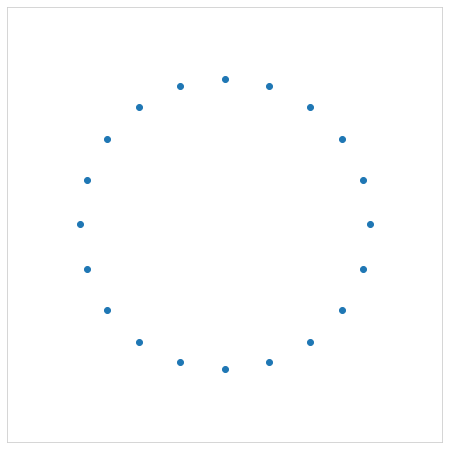

In [25]:
model = TrafficModel(20)
visualize_model(model)
model.step()

plt.show()

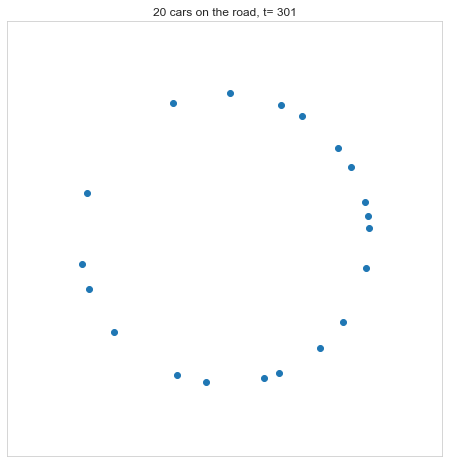

In [26]:
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc, collections
from matplotlib import pyplot as plt
from IPython.display import HTML

number_of_cars = 20
model = TrafficModel(number_of_cars)

fig, points = visualize_model(model)
ax = plt.gca()


def update(frame):
    model.step()
    
    positions = [agent.pos for agent in model.agents]
    
    x_position = np.cos(positions)
    y_position = np.sin(positions)    
    pos = np.asarray([x_position, y_position]).T
    
    points.set_offsets(pos)
    ax.set(title=str(number_of_cars) + " cars on the road, t= " + str(model.scheduler.steps))

    return positions

anim = FuncAnimation(fig, update, interval=100, frames=300);
HTML(anim.to_html5_video())  

#writervideo = animation.FFMpegWriter(fps=12,bitrate=900) 
#anim.save("cars.mp4", writer=writervideo,dpi=200)